##Step 3: [최종] 불량 부품 탐지

In [ ]:
import os
import cv2
import torch
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F
import torchvision.models.detection as models_detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_path = '/content/drive/MyDrive/Deeplearning/Teamproject/faster_rcnn_model3.pth'
num_classes = 7  # 저장된 모델의 클래스 수

# 모델을 정의하고, 예측기를 설정
model = models_detection.fasterrcnn_resnet50_fpn(weights=None)  # 모델 구조 정의
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 모델 상태 불러오기
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

# GPU 사용 가능 여부에 따라 모델을 적절한 장치로 이동
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

# Keras 모델 로드
bolt_nut_model = load_model('/content/drive/MyDrive/Deeplearning/Teamproject/bolt-nut_model.h5')
tie_model = load_model('/content/drive/MyDrive/Deeplearning/Teamproject/tie_model.h5')
fishplate_model = load_model('/content/drive/MyDrive/Deeplearning/Teamproject/fishplate_model.h5')
screw_spike_model = load_model('/content/drive/MyDrive/Deeplearning/Teamproject/screw_spike_model.h5')

print("All models loaded and moved to device successfully.")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


All models loaded and moved to device successfully.


In [ ]:
class_names = {
    0: 'pandrol_e-clip',
    1: 'bolt-nut',
    2: 'tie',
    3: 'Insulation_block',
    4: 'screw_spike',
    5: 'fishplate'
}

def preprocess_image(image, target_size):
    # 이미지 크기 조정 및 정규화
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # 배치 차원 추가
    return image

def plot_image_with_predictions(image, predictions):
    # 이미지를 CPU로 옮겨서 NumPy 배열로 변환
    image = image.cpu().numpy()
    # 이미지의 축 변경
    image = np.transpose(image, (1, 2, 0))

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    predicted_classes = []
    for box, label in zip(predictions[0]['boxes'], predictions[0]['labels']):
        xmin, ymin, xmax, ymax = box.cpu().numpy()  # 바운딩 박스 좌표를 호스트 메모리로 복사하여 NumPy 배열로 변환
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

        # 바운딩 박스에서 이미지 영역을 크롭
        cropped_image = image[int(ymin):int(ymax), int(xmin):int(xmax)]

        # 바운딩 박스에 해당하는 클래스 이름 가져오기
        class_name = class_names[label.item()]

        # 바운딩 박스와 함께 이미지를 시각화
        ax.text(xmin, ymin, class_name, bbox=dict(facecolor='b', alpha=0.5))
        predicted_classes.append((cropped_image, class_name))

        if label == 1:  # bolt-nut
            prediction = bolt_nut_model.predict(preprocess_image(cropped_image, (150, 150)))
            prediction_class = 'Abnormal' if prediction[0] < 0.95 else 'Normal'
            color = 'red' if prediction_class == 'Abnormal' else 'green'
            ax.text(xmin, ymin, f'bolt-nut: {prediction_class}', bbox=dict(facecolor=color, alpha=0.5))
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')

            ax.add_patch(rect)
        if label == 2:  # Tie
            prediction = tie_model.predict(preprocess_image(cropped_image, (150, 150)))
            prediction_class = 'Abnormal' if prediction[0] < 0.95 else 'Normal'
            color = 'red' if prediction_class == 'Abnormal' else 'green'
            ax.text(xmin, ymin, f'Tie: {prediction_class}', bbox=dict(facecolor=color, alpha=0.5))
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

        elif label == 4:  # screw_spike
            prediction = screw_spike_model.predict(preprocess_image(cropped_image, (150, 150)))
            prediction_class = 'Abnormal' if prediction[0] < 0.95 else 'Normal'
            color = 'red' if prediction_class == 'Abnormal' else 'green'
            ax.text(xmin, ymin, f'screw_spike: {prediction_class}', bbox=dict(facecolor=color, alpha=0.5))
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

        elif label == 5:  # Fishplate
            prediction = fishplate_model.predict(preprocess_image(cropped_image, (150, 150)))
            prediction_class = 'Abnormal' if prediction[0] < 0.95 else 'Normal'
            color = 'red' if prediction_class == 'Abnormal' else 'green'
            ax.text(xmin, ymin, f'Fishplate: {prediction_class}', bbox=dict(facecolor=color, alpha=0.5))
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()

    return predicted_classes

1/1 [==============================] - 0s 22ms/step


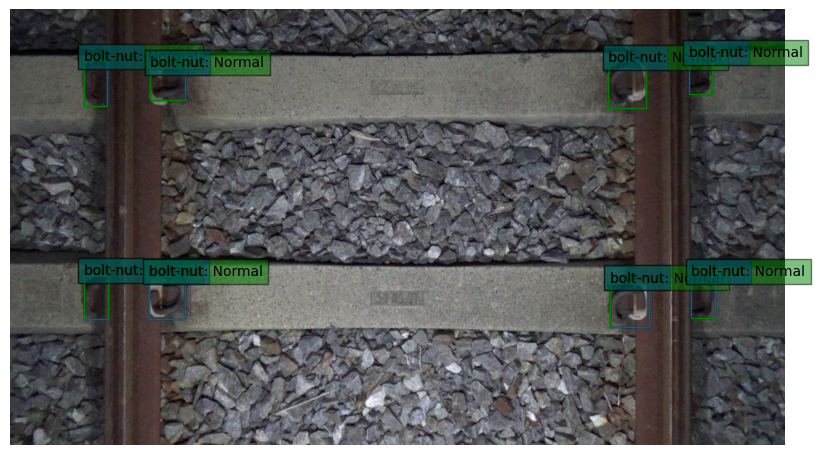

1/1 [==============================] - 0s 22ms/step


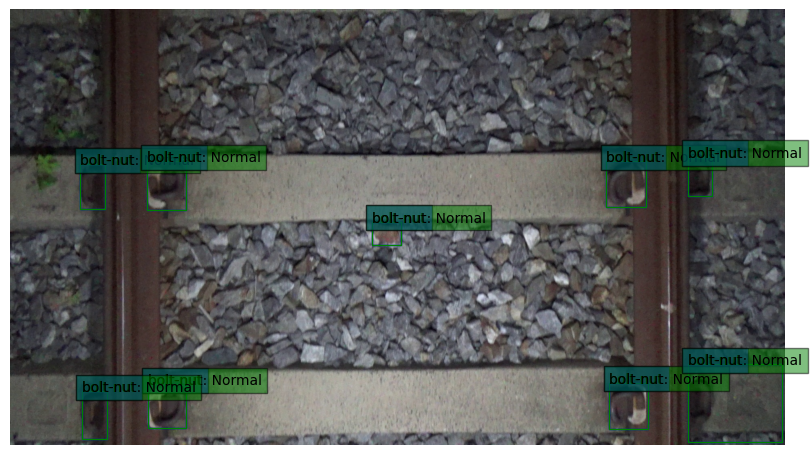

1/1 [==============================] - 0s 21ms/step


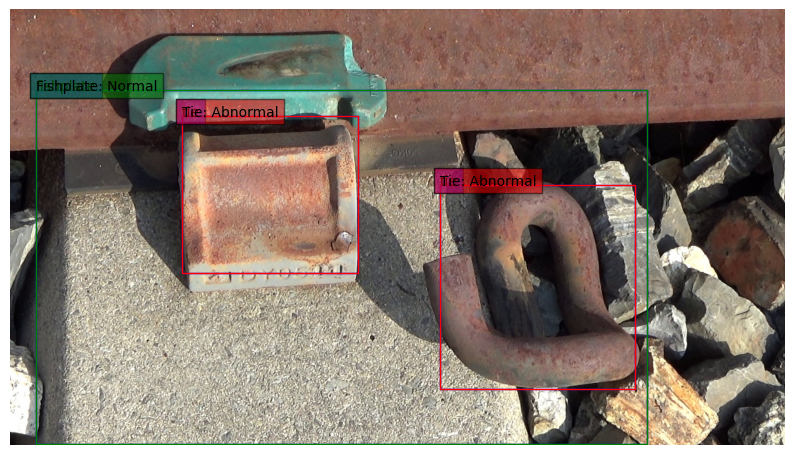

1/1 [==============================] - 0s 22ms/step


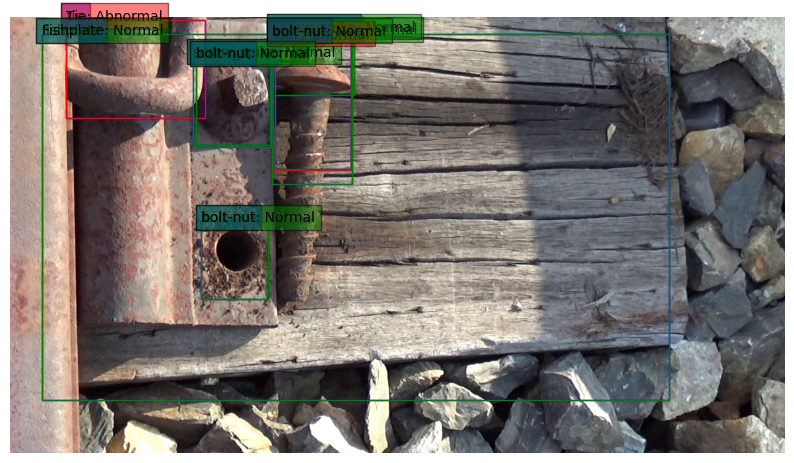

1/1 [==============================] - 0s 29ms/step


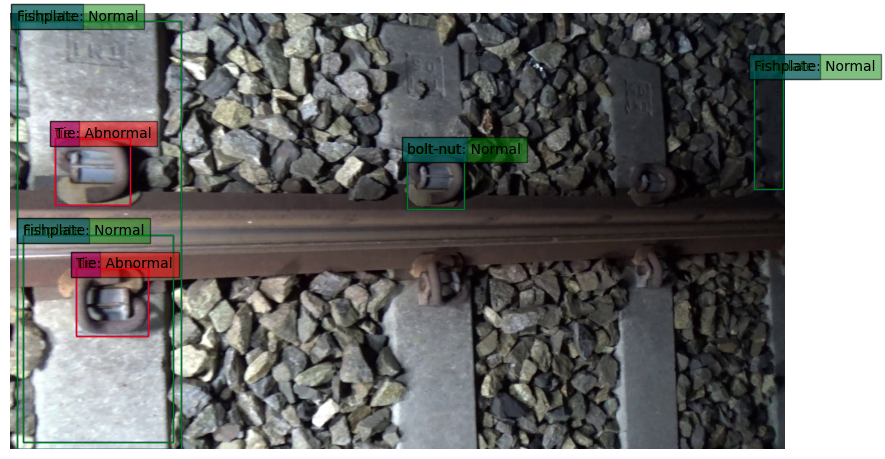

1/1 [==============================] - 0s 21ms/step


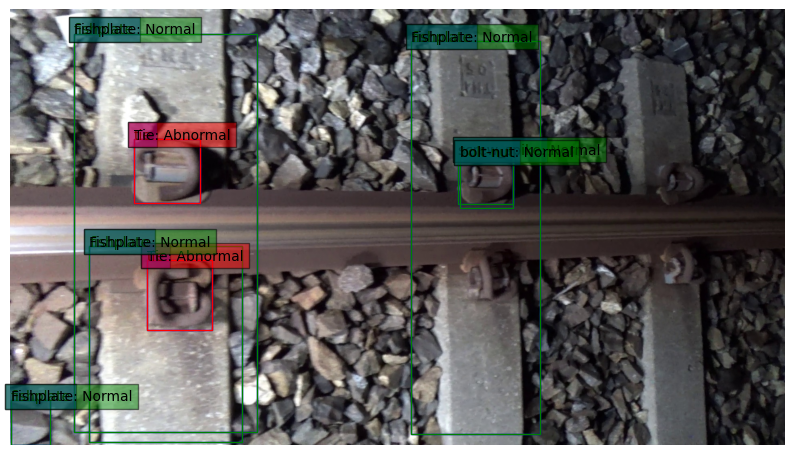

1/1 [==============================] - 0s 22ms/step


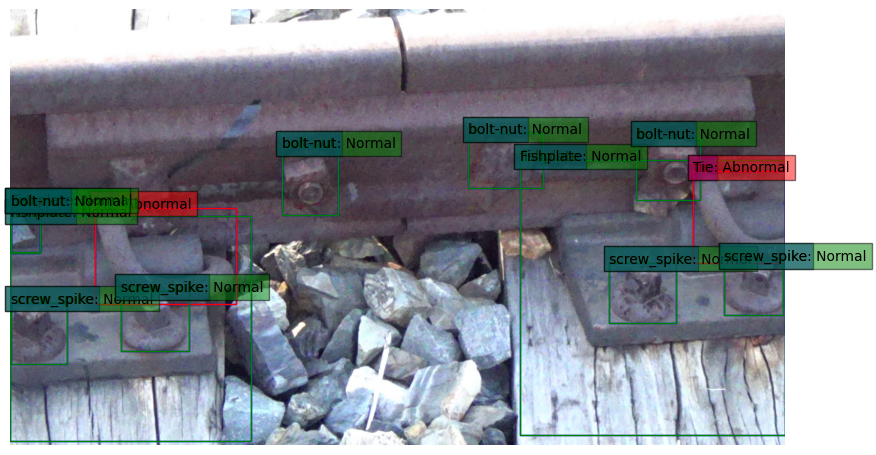

1/1 [==============================] - 0s 21ms/step


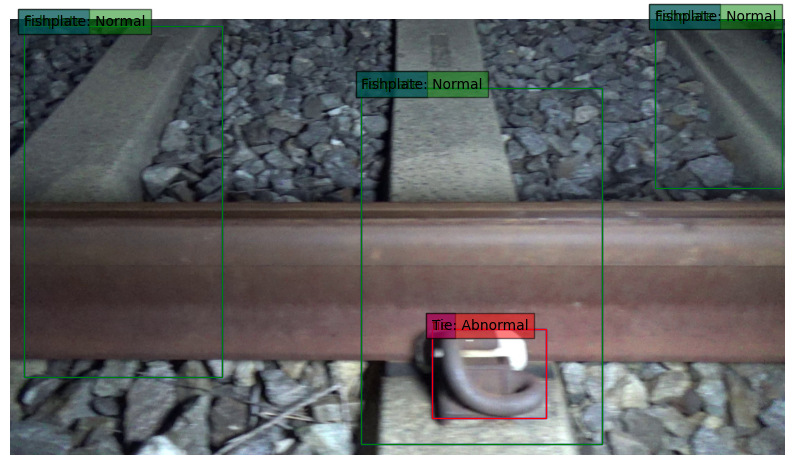

1/1 [==============================] - 0s 25ms/step


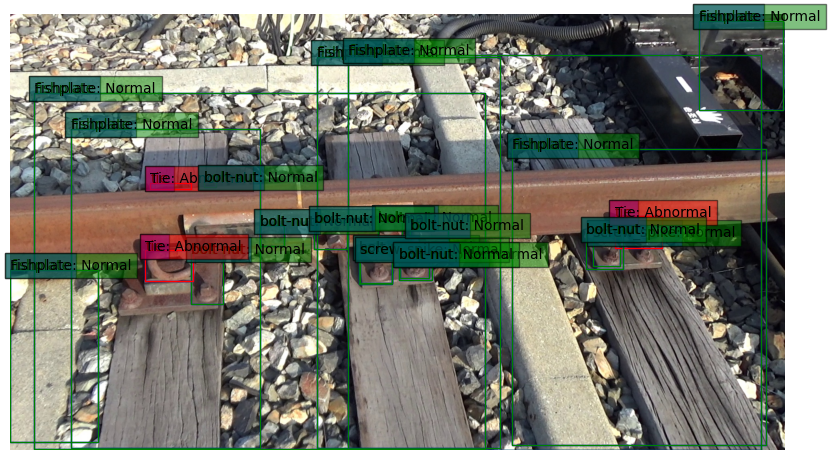

1/1 [==============================] - 0s 23ms/step


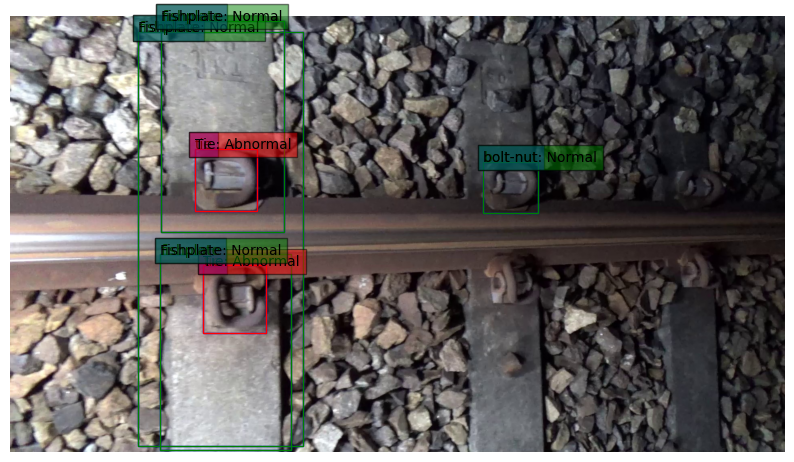

Random 10 images processed successfully.


In [ ]:
import random

def load_and_prepare_image(image_path, device):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 이미지를 PyTorch 텐서로 변환
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    return image, image_tensor

# 상위 폴더 경로 설정
folder_path = "/content/drive/MyDrive/Deeplearning/Teamproject/일반철도_원천"

# 폴더 내 모든 이미지 파일 목록 가져오기
all_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".png")]

# 무작위로 10개의 파일 선택
selected_files = random.sample(all_files, 10)

# 선택된 파일에 대해 예측 수행
for filename in selected_files:
    image_path = os.path.join(folder_path, filename)
    image, image_tensor = load_and_prepare_image(image_path, device)
    # 모델로 예측 수행
    with torch.no_grad():
        predictions = model(image_tensor)
    # 결과 시각화
    plot_image_with_predictions(image_tensor.squeeze(), predictions)

print("Random 10 images processed successfully.")